In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>


# Text classification with NLTK and Scikit-Learn
## Summary: 
### We have collected data from two different categories: Hotels and Travel & Health and medical, cleaned the text and transformed it to a suitable representation, in this case we implemented a Bag of Words model.  Both categories contain an imbalanced amount of classes so we have to evaluate them using Precision-Recall curves and Avg. Precision. We  test different classifiers and finally train the models using a Naive Bayes model (as it perfomes the best compared to rest). We reach an average precision of 95%

### Student name: Ruben Alvarez Martinez
### Student number: 17201506

In [7]:
# from standard python library
import re, string 
import os
import urllib.request
import warnings
warnings.filterwarnings('ignore')

# third party libraries: BeautifulSoup, Numpy, Pandas, NLTK, Sklearn
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import sklearn
from sklearn.model_selection import cross_val_score, cross_val_predict
from joblib import load, dump
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn import ensemble, naive_bayes, svm, tree
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve, average_precision_score, f1_score
from sklearn.metrics import average_precision_score
from sklearn import preprocessing

%matplotlib inline
import matplotlib.pyplot as plt

## We are thinking of testing different classifiers with our datasets, we will create a class to handle all the tests at once and return the best classifier.

In [8]:
class TestClassifiers(object):

    def __init__(self, X, y, classifiers=None, scoring="accuracy"):
        
        self.X = X
        self.y = y
        
        if classifiers is None:
            self.classifiers = []
        self.classifiers = classifiers
        
        self.scoring = scoring
        
        # attribute asigned in call_fit method
        self.scores = []
        self.preds = []

    
    def cv_on_classifiers(self, folds=5):
        """ Apply cross validation on all classifiers
        """

        for classifier in self.classifiers:
            print("Cross-Validation using {} Classifier".format(type(classifier).__name__))
            score = cross_val_score(classifier, self.X, self.y, scoring=self.scoring, cv=folds)
            print("Scores:", score, "Mean score:", np.mean(score))
            self.scores.append(np.mean(score))
    
    def cv_pred_on_classifiers(self, folds=5, method='predict'):
        """ Apply cross validation predict on all classifiers
        """

        for classifier in self.classifiers:
            print("Predictions using Cross-Validation with {} Classifier".format(type(classifier).__name__))
            preds = cross_val_predict(classifier, self.X, self.y, cv=folds, n_jobs=5, method='predict')
            self.preds.append(preds)


    def fit_on_classifiers(self, prefix="", dump_=True):
        """ Apply fit method to all classifiers
        """

        for classifier in self.classifiers:
            print("Fitting {} Classifier".format(type(classifier).__name__))
            classifier.fit(self.X, self.y)
            print("Finished training classifier ", str(classifier))
            
            if dump_:
                dump(classifier, "../models/{}_{}.joblib".format(type(classifier).__name__, prefix))
    

    def best_classifier(self):
        """ Returns the classifier with the max score
        """
        print("Best classifier: \n")
        max_ = self.scores.index(np.max(self.scores))
        return self.classifiers[max_]


    def load_classifiers(self):
        """ Load classifiers from file
        """
        for classifier in self.classifiers:
            classifier = load("models/{}.joblib".format(type(classifier).__name__))


## Let's leave this class aside for a second, we will come back to it after downloading and processing our data. We will focus on only two categories out of the 5, "Health and medical" and "Hotels and travel":

In [7]:
def parse_html(url):
    response = urllib.request.urlopen(url)
    html_doc = response.read()
    return BeautifulSoup(html_doc, 'html.parser')

def explore_and_download(url):
    # Fetch the html file: http://mlg.ucd.ie/modules/yalp/
    soup = parse_html(url)
    all_reviews = []
    all_stars = []
    # links at home page
    for i, link in enumerate(soup.find_all('a')):
        #Category: Automotive
        #Category: Bars
        #Category: Health and medical
        #Category: Hotels and travel
        #Category: Restaurant
        if i == 2 or i == 3: # 'Health & Medical' and 'Hotels & Travel'
            
            soup = parse_html(url+link.get('href'))
            # links level 2 (businesses)
            for link_2 in soup.find_all('a'):
                # List of 122 businesses in the category Health and medical
                # List of all 89 businesses in the category Hotels and travel
                print(link_2.get('href'))
                # access link & get reviews
                soup_2 = parse_html(url + link_2.get('href'))
                # find the scores:
                for p in soup_2.find_all('img'):
                    try: #the first entry has no attribute 'alt'
                        all_stars.append(p['alt'])
                    except:
                        pass
                # find the reviews:
                for p in soup_2.find_all('p'):
                    if p['class'][0] == 'text':
                        all_reviews.append(p.get_text())

            # concatenate and save the results
            results = np.concatenate((np.array(all_stars).reshape(-1,1), np.array(all_reviews).reshape(-1,1)), axis=1)
            pd.DataFrame(results, columns=['rate','review']).to_csv('../csv/' + link.get_text()[10:] + '.csv', index=False)

## Let's see what our Health and medical dataset looks like:

In [16]:
base_url = "http://mlg.ucd.ie/modules/yalp/"

if not os.path.isfile('../csv/Health and medical.csv'):
    explore_and_download(base_url)
    
health = pd.read_csv('../csv/Health and medical.csv')
health

,rate,review
0,5-star,I have so many good things to say about this p...
1,5-star,I found them to be highly skilled and an exper...
2,5-star,Where do I even begin? This office has been so...
3,5-star,I went in because I had toothache and needed a...
4,5-star,Found a new dental office. This place is amazi...
5,5-star,"Dr. Carlos is always on top of things, I've ne..."
6,5-star,Dr. Carlos and the staff were very friendly. T...
7,5-star,Love these guys! Had a chip in my tooth and no...
8,5-star,I just found this office in Scottsdale and the...
9,5-star,Dr. Mandap has been my dentist for many years ...


# Now let's take a look at Hotels and travel:

In [14]:
if not os.path.isfile('../csv/Hotels and travel.csv'):
    explore_and_download(base_url)

hotels = pd.read_csv('../csv/Hotels and travel.csv')
hotels

,rate,review
0,5-star,I have so many good things to say about this p...
1,5-star,I found them to be highly skilled and an exper...
2,5-star,Where do I even begin? This office has been so...
3,5-star,I went in because I had toothache and needed a...
4,5-star,Found a new dental office. This place is amazi...
5,5-star,"Dr. Carlos is always on top of things, I've ne..."
6,5-star,Dr. Carlos and the staff were very friendly. T...
7,5-star,Love these guys! Had a chip in my tooth and no...
8,5-star,I just found this office in Scottsdale and the...
9,5-star,Dr. Mandap has been my dentist for many years ...


# Now let's classify the stars rating into two groups, 1-3 stars: negative and 4-5: positive

In [22]:
if not os.path.isfile('../csv/Health and medical (classified).csv'):
    classify_stars('../csv/Health and medical.csv', '../csv/Health and medical (classified).csv')
if not os.path.isfile('../csv/Hotels and travel (classified).csv'):
    classify_stars('../csv/Hotels and travel.csv', '../csv/Hotels and travel (classified).csv')

health = pd.read_csv('../csv/Hotels and travel (classified).csv', index_col=0)
hotels = pd.read_csv('../csv/Health and medical (classified).csv', index_col=0)
health, hotels

(        rate                                             review     class
 0     5-star  I have so many good things to say about this p...  positive
 1     5-star  I found them to be highly skilled and an exper...  positive
 2     5-star  Where do I even begin? This office has been so...  positive
 3     5-star  I went in because I had toothache and needed a...  positive
 4     5-star  Found a new dental office. This place is amazi...  positive
 5     5-star  Dr. Carlos is always on top of things, I've ne...  positive
 6     5-star  Dr. Carlos and the staff were very friendly. T...  positive
 7     5-star  Love these guys! Had a chip in my tooth and no...  positive
 8     5-star  I just found this office in Scottsdale and the...  positive
 9     5-star  Dr. Mandap has been my dentist for many years ...  positive
 10    5-star  A bit of a drive on the freeways but this plac...  positive
 11    1-star  Wow. Do not order from here. I ordered an item...  negative
 12    1-star  I was sear

# Let's look at the classes distribution:

In [124]:
hotels.groupby('class')['class'].count()

class
negative     407
positive    1043
Name: class, dtype: int64

In [125]:
health.groupby('class')['class'].count()

class
negative    1044
positive    1836
Name: class, dtype: int64

# ATENTION: Our classes are not evenly distributed, meaning that accuracy might not be a great indicator of a good performance, instead we will measure, precision and recall.


## When to Use ROC vs. Precision-Recall Curves?
### Generally, the use of ROC curves and precision-recall curves are as follows:

##### * ROC curves should be used when there are roughly equal numbers of observations for each class. 

#### * Precision-Recall curves should be used when there is a moderate to large class imbalance.

##### The reason for this recommendation is that ROC curves present an optimistic picture of the model on datasets with a class imbalance.


## As our machine learning techniques do not know how to process raw text, we need to transform it into a suitable representation. We will use the Bag of  Word model.

## We define a set of methods that together will create a pipeline of transformations:

In [24]:
def filter_words(raw_comments):
    """ Returns a filtered list
        Removes numbers and symbols from each comment
    """
    table = str.maketrans('', '', string.punctuation + string.digits)
    stripped = [comment.translate(table) for comment in raw_comments]
    return stripped

def lowercase_all(comments):
    """ Returns a list of lowercased words
    """
    return [comment.lower() for comment in comments]

def split_words(comments):
    """ Splits each comment as a list of strings, where each string is a word
    """
    return [re.split(r'\W+', comment) for comment in comments]

def flatten_words(comments):
    """ Returns a list of strings, where each string is a word
    """
    return [word for comment in comments for word in comment]

def remove_stopwords(words):
    """ Returns a list filter out stop words
    """
    stop_words = set(stopwords.words('english'))
    return [word for word in words if not word in stop_words]

def lemmatize(words):
    """ Lemma conversion
    """
    lem = WordNetLemmatizer()
    return [lem.lemmatize(word) for word in words]

def stemming(words):
    """ Linguistic normalization
    """
    ps = PorterStemmer()
    return [ps.stem(word) for word in words]


## As we will use each word as features and eventually we want to test each classifier on a dataset other than the one it was trained on, we need to define a common set of features:

In [25]:
# take both files and concatenate them together:
if not os.path.isfile('../csv/concat_categories.csv'):    
    cat_1 = pd.read_csv('../csv/Hotels and travel (classified).csv')
    cat_2 = pd.read_csv('../csv/Health and medical (classified).csv')
    cats = pd.concat([cat_1, cat_2], ignore_index=True)
    cats.to_csv('../csv/concat_categories.csv')

## Now, let's start our transformation pipeline for each of the files, we will use the concatenated files to define a vocabulary:

In [27]:
def create_vocabulary(path_read):
    
    data = pd.read_csv(path_read)
    # strip reviews and place them in a single list
    raw_comments = list(data['review'])

    # Create vocabulary
    filtered = filter_words(raw_comments)
    splitted = split_words(filtered)
    flattened = flatten_words(splitted)
    words = lowercase_all(flattened)
    words = remove_stopwords(words)
    words = lemmatize(words)
    words = stemming(words)
    return sorted(list(set(words)))


def document_term_matrix(path_read, path_write):
   
    # call and create vocabulary
    vocabulary =  create_vocabulary('../csv/concat_categories.csv')

    data = pd.read_csv(path_read)
    # strip reviews and place them in a single list
    raw_comments = list(data['review'])

    # Document-Term Matrix
    # Count frequency of words per comment
    filtered = filter_words(raw_comments)
    comments_as_words = lowercase_all(filtered)
    comments_as_words = split_words(comments_as_words)
    
    # allocate memory for efficiency, a matrix of 
    # rows = number of comments in the file and 
    # columns = number of words in vocabulary
    dtm = np.zeros((len(list(data['review'])), len(vocabulary)), dtype=np.int8, order='F')
    
    # for each comment in all the comments in the file
    for i, comment in enumerate(comments_as_words):
        # continue pipeline per comment
        cleaned_comment = remove_stopwords(comment)
        comment_lem = lemmatize(cleaned_comment)
        comment_stem = stemming(comment_lem)
        # count frequency of words in comment 
        uniques_count = pd.DataFrame(np.array(comment_stem).reshape(-1,1), columns=['words']).groupby(['words'])['words'].count()
        
        # assign the frequency of each word to the dtm matrix:
        for word in uniques_count.index:
            dtm[i, vocabulary.index(word)] = uniques_count[word]
    # save results    
    pd.DataFrame(dtm, columns=vocabulary).to_csv(path_write)


In [28]:
if not os.path.isfile('../csv/Hotels and travel dtm.csv'):
    document_term_matrix( '../csv/Hotels and travel (classified).csv', '../csv/Hotels and travel dtm.csv')

if not os.path.isfile('../csv/Health and medical dtm.csv'):
    document_term_matrix( '../csv/Health and medical (classified).csv', '../csv/Health and medical dtm.csv')

## It is important to notice that this strategy produces a sparse matrix, which is not very ideal for memory purposes.

In [31]:
pd.read_csv('../csv/Hotels and travel dtm.csv', index_col=0)

,Unnamed: 1,aa,aaa,aan,aat,abalo,abbey,abbrevi,abdomen,abdomin,...,écrit,égaux,élaboré,était,étant,été,évident,ête,être,über
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Our data is finally ready for training, we will be using our first defined class to test a set of three different classifiers, we expect naive bayes to do better than the rest because of the sparsity of the data:

In [14]:
def model_building(path_read_x, path_read_y, model_name):

    x_data = pd.read_csv(path_read_x, index_col=0)
    y_data = pd.read_csv(path_read_y, index_col=0)
    y_data = y_data['class']

    X_train, X_test_val, y_train, y_test_val = train_test_split(x_data, y_data,  test_size=0.3, random_state=1)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val,  test_size=0.3, random_state=1)
    
    # configure models and leave default values as is:
    naive = naive_bayes.MultinomialNB()
    sgd = SGDClassifier(n_jobs=4)
    svmc = tree.DecisionTreeClassifier()
    
    clfs = [naive, sgd, svmc]
    # we will score the cross validation with roc_auc:
    # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    test_clfs = TestClassifiers(X_train, y_train, classifiers=clfs, scoring='accuracy')
    test_clfs.cv_on_classifiers(folds=5)
    best_classifier = test_clfs.best_classifier()
    
    
    # get predictions with best_classifier
    test_clf = TestClassifiers(X_train, y_train, classifiers=[best_classifier])
    test_clf.cv_pred_on_classifiers(method='predict_proba')
    print(best_classifier)
    
    #curve needs binary/numeric values, transform the labels to 0 and 1
    le = preprocessing.LabelEncoder()
    le.fit(['positive', 'negative'])
    y_pred = le.transform(test_clf.preds[0])
    y_train = le.transform(np.array(y_train))
    
    #print(np.array(y_train))
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred)
    #fpr, tpr, thresholds = roc_curve(np.array(y_train_trans), np.array(y_pred_trans), pos_label=1)
    #area = auc(fpr, tpr)
    f1 = f1_score(y_train, y_pred )
    # calculate precision-recall AUC
    auc_ = auc(recall, precision)
    # calculate average precision score
    ap = average_precision_score(y_train, y_pred, pos_label=1)
    print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_, ap))
    
    plt.figure() 
    lw = 2
    fig = plt.gcf()
    fig.set_size_inches(12, 10)
    plt.plot(recall, precision, color='darkorange',
             lw=lw, label='AUC (area = %0.2f)' % auc_)
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (training data)',  fontsize=20)
    plt.legend(loc="lower right")
    
    return best_classifier

## Test a Naive Bayes classifier, a SGD classifier and a Decision Tree classifier using 5 fold cross-validation, then return the best of them over the Hotels and Travel category

Cross-Validation using MultinomialNB Classifier
Scores: [0.88118812 0.86600496 0.89330025 0.92307692 0.91563275] Mean score: 0.8958406014298701
Cross-Validation using SGDClassifier Classifier
Scores: [0.86138614 0.86352357 0.87841191 0.87344913 0.90322581] Mean score: 0.875999312090018
Cross-Validation using DecisionTreeClassifier Classifier
Scores: [0.74257426 0.76923077 0.78411911 0.75434243 0.79652605] Mean score: 0.7693585239417242
Best classifier: 

Predictions using Cross-Validation with MultinomialNB Classifier
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
f1=0.918 auc=0.942 ap=0.890


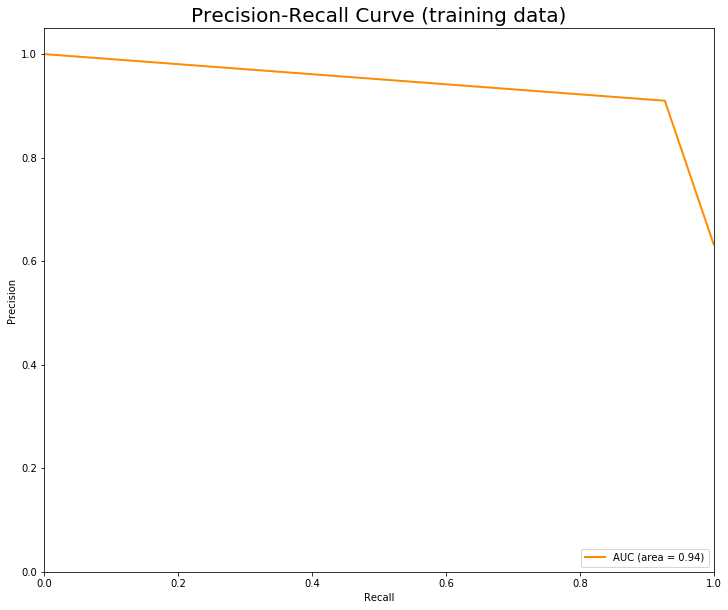

In [15]:
if not os.path.isfile('../models/MultinomialNB_model_ht.joblib'):
    best_classifier_1 = model_building('../csv/Hotels and travel dtm.csv', '../csv/Hotels and travel (classified).csv', 'model_ht')

## The best classifier was the Naive Bayes, with an avg. precision of 89%

## We proceed to do the same for the Health and medical category:

Cross-Validation using MultinomialNB Classifier
Scores: [0.97476568 0.95650084 0.95445806 0.91606585 0.97116078] Mean score: 0.954590242730113
Cross-Validation using SGDClassifier Classifier
Scores: [0.95085316 0.9513939  0.94688777 0.92093247 0.94766883] Mean score: 0.9435472242249461
Cross-Validation using DecisionTreeClassifier Classifier
Scores: [0.73317712 0.72632781 0.74194905 0.77319154 0.75606825] Mean score: 0.7461427541456381
Best classifier: 

Predictions using Cross-Validation with MultinomialNB Classifier
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
f1=0.942 auc=0.951 ap=0.904


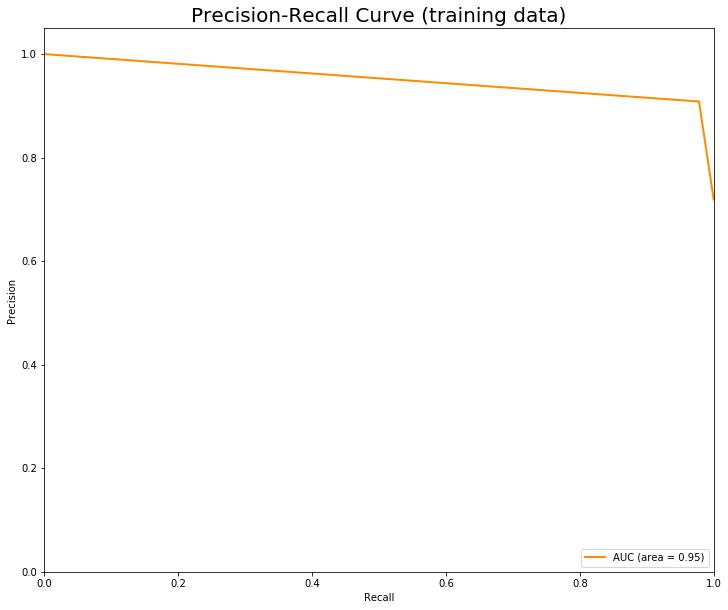

In [322]:
if not os.path.isfile('../models/MultinomialNB_model_hm.joblib'):
    best_classifier_2 = model_building('../csv/Health and medical dtm.csv', '../csv/Health and medical (classified).csv', 'model_hm')

## Same as before, Naive Bayes is the best with avg. precision of 90.4%
## These results are looking promissing.

## Let's train the models on the training data and run them on the test data:

f1=0.930 auc=0.949 ap=0.902


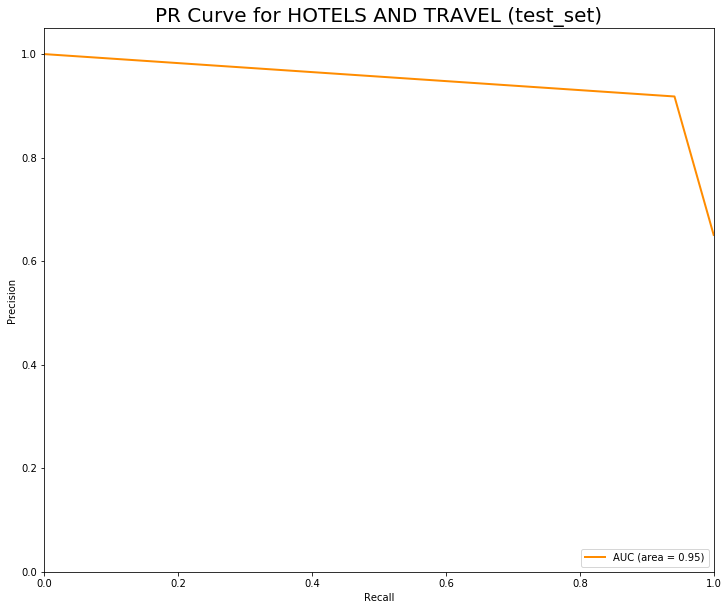

In [323]:
x_data = pd.read_csv('../csv/Hotels and travel dtm.csv', index_col=0)
y_data = pd.read_csv('../csv/Hotels and travel (classified).csv', index_col=0)
y_data = y_data['class']

X_train, X_test_val, y_train, y_test_val = train_test_split(x_data, y_data,  test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val,  test_size=0.3, random_state=1)

#fit best classifier with filtered data
best_classifier_1.fit(X_train, y_train)
#produce some predictions
y_pred = best_classifier_1.predict(X_test)


#curve needs binary/numeric values, transform the labels to 0 and 1
le = preprocessing.LabelEncoder()
le.fit(['positive', 'negative'])
y_pred = le.transform(y_pred)
y_test = le.transform(y_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
f1 = f1_score(y_test, y_pred )

# calculate precision-recall AUC
auc_ = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(y_test, y_pred, pos_label=1)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_, ap))
    

plt.figure() 
lw = 2
fig = plt.gcf()
fig.set_size_inches(12, 10)
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='AUC (area = %0.2f)' % auc_)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for HOTELS AND TRAVEL (test_set)',  fontsize=20)
plt.legend(loc="lower right")


## We seem to be able to generalize from our training data, as we are getting about the same values in avg. precision = 90.2%

## We run the same analysis on the health and medical data

f1=0.945 auc=0.953 ap=0.908


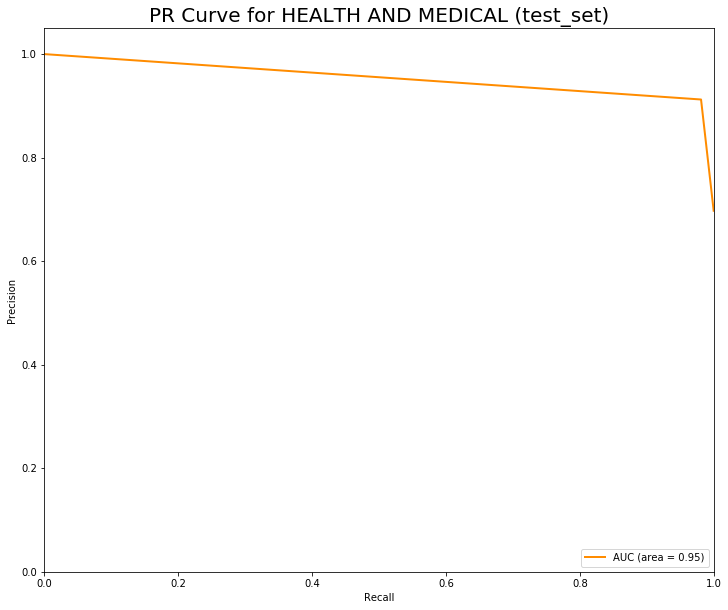

In [324]:
x_data = pd.read_csv('../csv/Health and medical dtm.csv', index_col=0)
y_data = pd.read_csv('../csv/Health and medical (classified).csv', index_col=0)
y_data = y_data['class']

X_train, X_test_val, y_train, y_test_val = train_test_split(x_data, y_data,  test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val,  test_size=0.3, random_state=1)

#fit best classifier with filtered data
best_classifier_2.fit(X_train, y_train)
#produce some predictions
y_pred = best_classifier_2.predict(X_test)

#encode the predictions
le = preprocessing.LabelEncoder()
le.fit(['positive', 'negative'])
y_test = le.transform(y_test)
y_pred = le.transform(y_pred)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
f1 = f1_score(y_test, y_pred )

# calculate precision-recall AUC
auc_ = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(y_test, y_pred, pos_label=1)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_, ap))
    

plt.figure() 
lw = 2
fig = plt.gcf()
fig.set_size_inches(12, 10)
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='AUC (area = %0.2f)' % auc_)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for HEALTH AND MEDICAL (test_set)' , fontsize=20)
plt.legend(loc="lower right")

## The results are really good, we are reaching an average precision of over 90% in both categories. For a dataset with such imbalance this is good news.

## Let's see if our learning transfer from one category to the other.

f1=0.933 auc=0.948 ap=0.900


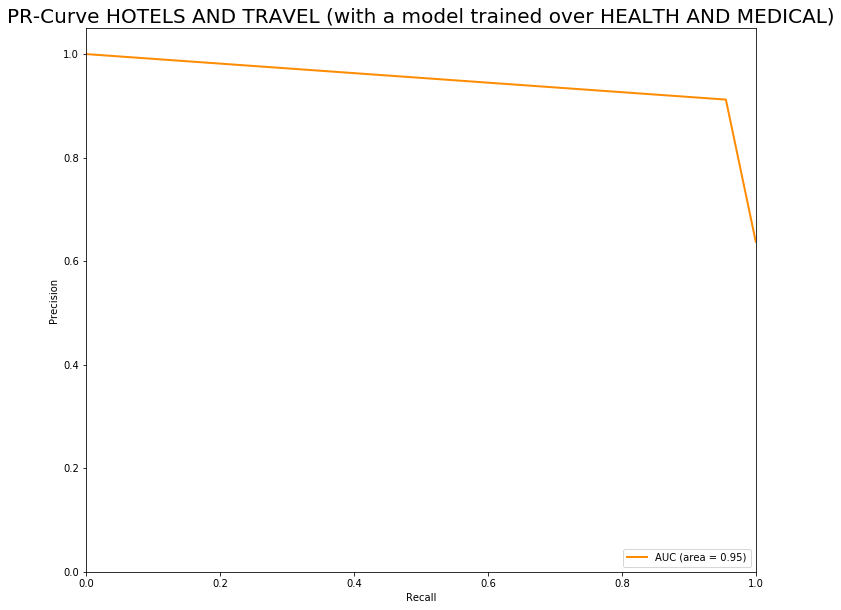

In [325]:
x_data = pd.read_csv('../csv/Health and medical dtm.csv', index_col=0)
y_data = pd.read_csv('../csv/Health and medical (classified).csv', index_col=0)
y_data = y_data['class']

X_train, X_test_val, y_train, y_test_val = train_test_split(x_data, y_data,  test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val,  test_size=0.3, random_state=1)

#fit best classifier with the whole training set (HEALTH AND MEDICAL)
best_classifier_2.fit(X_train, y_train)
dump(best_classifier_2, "../models/Naive_model_hm.joblib")

#produce some predictions using the other category as input
x_data = pd.read_csv('../csv/Hotels and travel dtm.csv', index_col=0)
y_data = pd.read_csv('../csv/Hotels and travel (classified).csv', index_col=0)
y_data = y_data['class']

y_pred = best_classifier_2.predict(x_data)

#encode the predictions
le = preprocessing.LabelEncoder()
le.fit(['positive', 'negative'])
y_test_ = le.transform(y_data)
y_pred_ = le.transform(y_pred)


precision, recall, thresholds = precision_recall_curve(y_test_, y_pred_)
f1 = f1_score(y_test_, y_pred_ )

# calculate precision-recall AUC
auc_ = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(y_test_, y_pred_, pos_label=1)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_, ap))
    
plt.figure() 
lw = 2
fig = plt.gcf()
fig.set_size_inches(12, 10)
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='AUC (area = %0.2f)' % auc_)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-Curve HOTELS AND TRAVEL (with a model trained over HEALTH AND MEDICAL)', fontsize=20)
plt.legend(loc="lower right")

In [326]:
print(classification_report(y_data, y_pred))

              precision    recall  f1-score   support

    negative       0.91      0.84      0.87      1044
    positive       0.91      0.96      0.93      1836

   micro avg       0.91      0.91      0.91      2880
   macro avg       0.91      0.90      0.90      2880
weighted avg       0.91      0.91      0.91      2880



## Great news, our model "best_classifier_2" it is generalizing well over data it has never seen before. Let's see if the same applies for "best_classifier_1":

f1=0.973 auc=0.978 ap=0.957


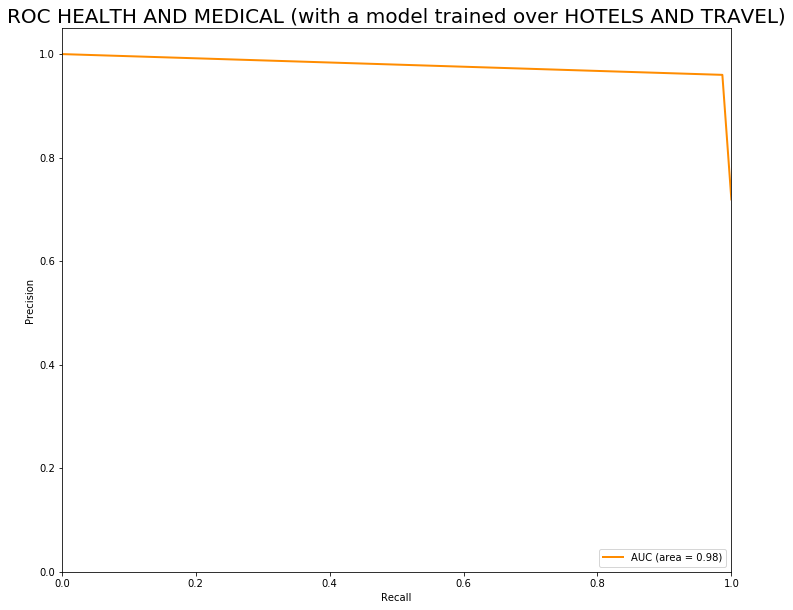

In [327]:
x_data = pd.read_csv('../csv/Hotels and travel dtm.csv', index_col=0)
y_data = pd.read_csv('../csv/Hotels and travel (classified).csv', index_col=0)
y_data = y_data['class']

X_train, X_test_val, y_train, y_test_val = train_test_split(x_data, y_data,  test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val,  test_size=0.3, random_state=1)

#fit best classifier with the whole training set (HOTELS AND TRAVEL)
best_classifier_1.fit(X_train, y_train)
dump(best_classifier_1, "../models/Naive_model_ht.joblib")

#produce some predictions using the other category as input
x_data = pd.read_csv('../csv/Health and medical dtm.csv', index_col=0)
y_data = pd.read_csv('../csv/Health and medical (classified).csv', index_col=0)
y_data = y_data['class']

y_pred = best_classifier_1.predict(x_data)

#encode the predictions
le = preprocessing.LabelEncoder()
le.fit(['positive', 'negative'])
y_test_ = le.transform(y_data)
y_pred_ = le.transform(y_pred)

precision, recall, thresholds = precision_recall_curve(y_test_, y_pred_)
f1 = f1_score(y_test_, y_pred_ )

# calculate precision-recall AUC
auc_ = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(y_test_, y_pred_, pos_label=1)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_, ap))
    
plt.figure() 
lw = 2
fig = plt.gcf()
fig.set_size_inches(12, 10)
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='AUC (area = %0.2f)' % auc_)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('ROC HEALTH AND MEDICAL (with a model trained over HOTELS AND TRAVEL)', fontsize=20)
plt.legend(loc="lower right")

In [328]:
print(classification_report(y_data, y_pred))

              precision    recall  f1-score   support

    negative       0.96      0.89      0.93       407
    positive       0.96      0.99      0.97      1043

   micro avg       0.96      0.96      0.96      1450
   macro avg       0.96      0.94      0.95      1450
weighted avg       0.96      0.96      0.96      1450



## Even better results, definetly this is due the amount of data, as the Hotels and Travel category contains twice more samples than the Health and Medical category. I would recommend then to deploy the model trained over Hotel and Travel.